In [14]:
import uproot as up
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak
import os

In [52]:
path_data_folder = "/remote/gpu07/huetsch/JetCalibration/data"

name = "Ak10Jet_1.root"

file = os.path.join(path_data_folder, name)
file = up.open(file)
tree = file['eventtree;46']
keys = tree.keys()

true_E = ak.to_numpy(tree["ak10_true_E"].array())
rec_E = ak.to_numpy(tree["ak10_E"].array())
E_ratio = rec_E / true_E

true_m = ak.to_numpy(tree["ak10_true_mass"].array())
rec_m = ak.to_numpy(tree["ak10_mass"].array())
m_ratio = rec_m / true_m

true_pt = ak.to_numpy(tree["ak10_true_pt"].array())
rec_pt = ak.to_numpy(tree["ak10_pt"].array())

true_pt_cut = true_pt > 100000
rec_pt_cut = rec_pt > 100000
true_mass_cut = true_m > 50000
rec_mass_cut = rec_m > 50000
full_cut = true_pt_cut & rec_pt_cut & true_mass_cut & rec_mass_cut

keys_to_keep = [
    'ak10_E',
    'ak10_mass',
    'ak10_rap',
    'ak10_groomMRatio',
    'ak10_Width',
    'ak10_Split12',
    'ak10_Split23',
    'ak10_C2',
    'ak10_D2',
    'ak10_Tau32',
    'ak10_Qw',
    'ak10_EMFracCaloBased',
    'ak10_EM3FracCaloBased',
    'ak10_Tile0FracCaloBased',
    'ak10_EffNClustsCaloBased',
    'ak10_NeutralEFrac',
    'ak10_ChargePTFrac',
    'ak10_ChargeMFrac',
    'averageMu',
    'NPV',    
]

inputs = np.array([ak.to_numpy(tree[key].array()) for key in keys_to_keep])
full_data = np.concatenate([E_ratio[:, None], m_ratio[:, None], inputs.T], axis=1)
print("Shape of full_data: ", full_data.shape)

full_data = full_data[full_cut]
print("Shape of full_data after cut: ", full_data.shape)

# apply a log transformation to the target ratios
full_data[:, 0] = np.log10(full_data[:, 0])
full_data[:, 1] = np.log10(full_data[:, 1])

nan_mask = np.isnan(full_data).any(1)
full_data = full_data[~nan_mask]
print("Shape of full_data after nan mask: ", full_data.shape)

np.save(os.path.join(path_data_folder, "Ak10Jet_1.npy"), full_data)

Shape of full_data:  (13000000, 22)
Shape of full_data after cut:  (5325740, 22)
Shape of full_data after nan mask:  (5325740, 22)


In [37]:
indices = [0, 1, 4, 6, 7, 11, 12, 24, 25, 26, 23]
print([keys[i] for i in indices if keys[i] in keys_to_keep])
print(keys_to_keep)

['ak10_E', 'ak10_mass', 'ak10_D2', 'ak10_Qw', 'ak10_NeutralEFrac', 'ak10_ChargePTFrac', 'ak10_ChargeMFrac', 'ak10_EffNClustsCaloBased']
['ak10_E', 'ak10_mass', 'ak10_rap', 'ak10_groomMRatio', 'ak10_Width', 'ak10_Split12', 'ak10_Split23', 'ak10_C2', 'ak10_D2', 'ak10_Tau32', 'ak10_Qw', 'ak10_EMFracCaloBased', 'ak10_EM3FracCaloBased', 'ak10_Tile0FracCaloBased', 'ak10_EffNClustsCaloBased', 'ak10_NeutralEFrac', 'ak10_ChargePTFrac', 'ak10_ChargeMFrac', 'averageMu', 'NPV']


In [46]:
log_dims = [0, 1, 5, 6, 8, 10, 18, 19]

In [62]:
inputs = full_data[:, 2:]

6.085468 0.32984975


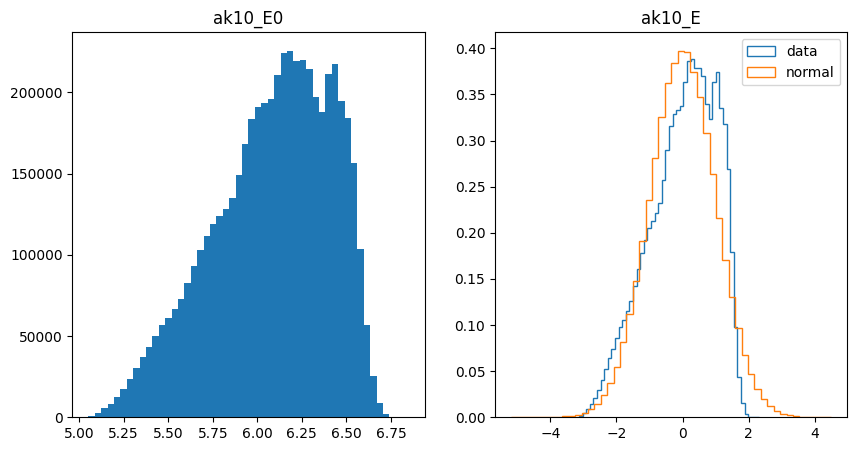

5.1427817 0.30633587


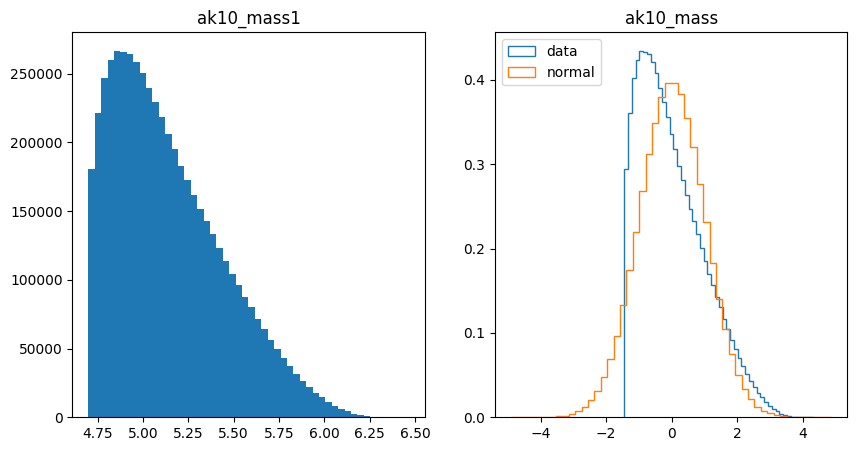

-0.0009429508 0.92751324


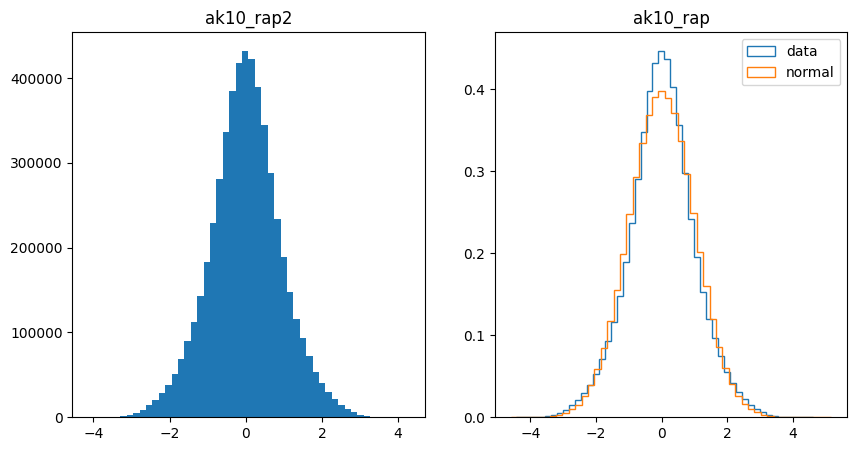

0.81375563 0.18470101


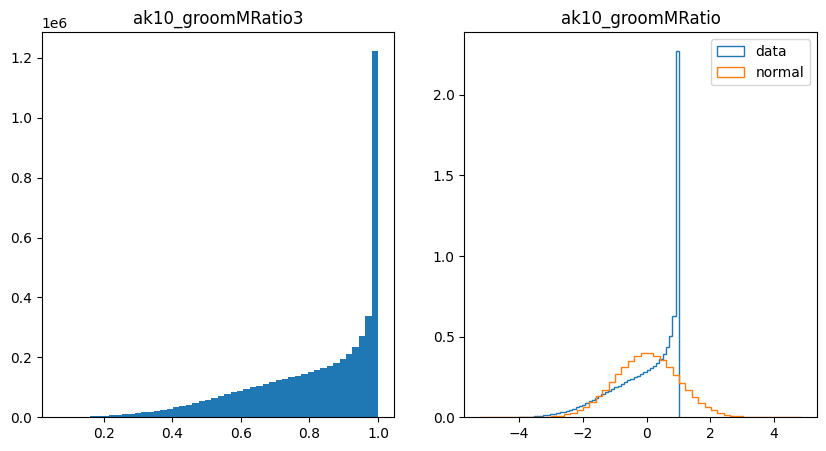

0.16571747 0.11864318


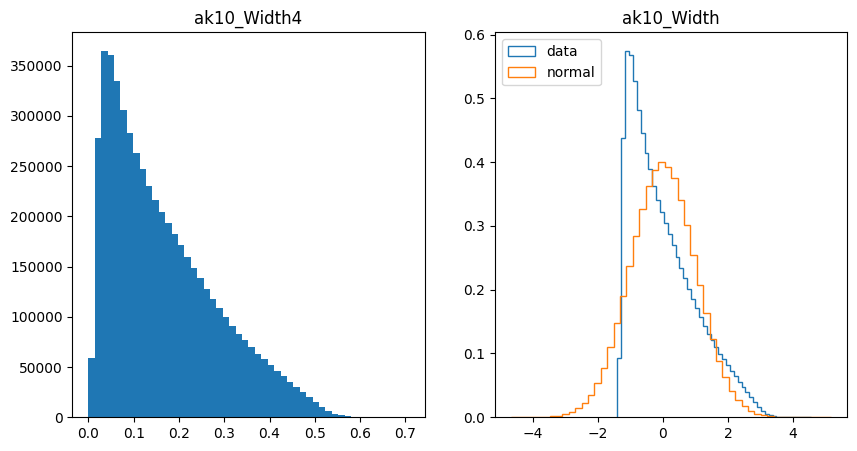

4.7276344 0.38762346


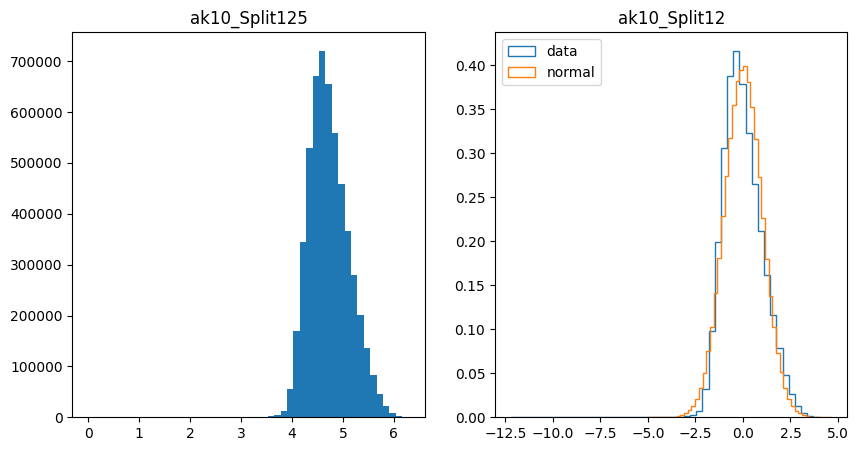

4.127239 0.3765261


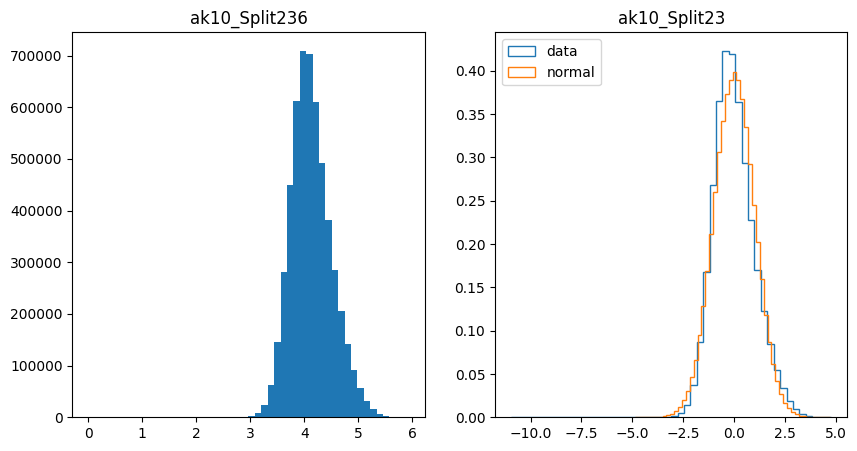

0.15900499 0.09990253


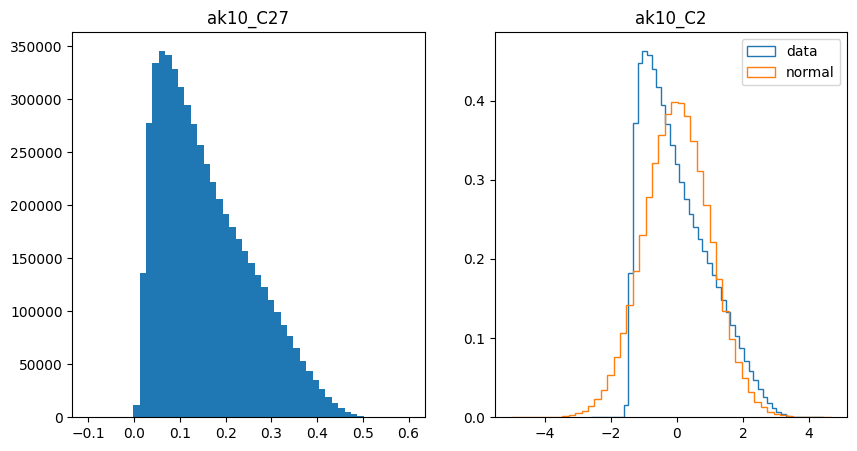

10.870738 0.5939803


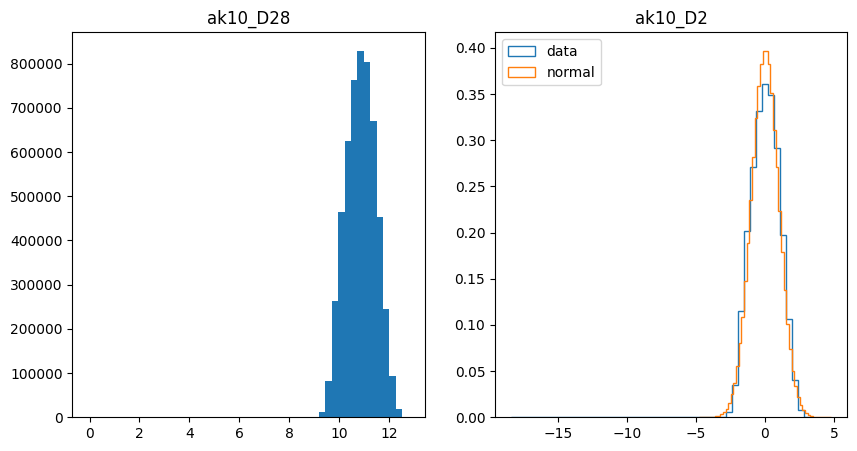

0.7037502 0.12523688


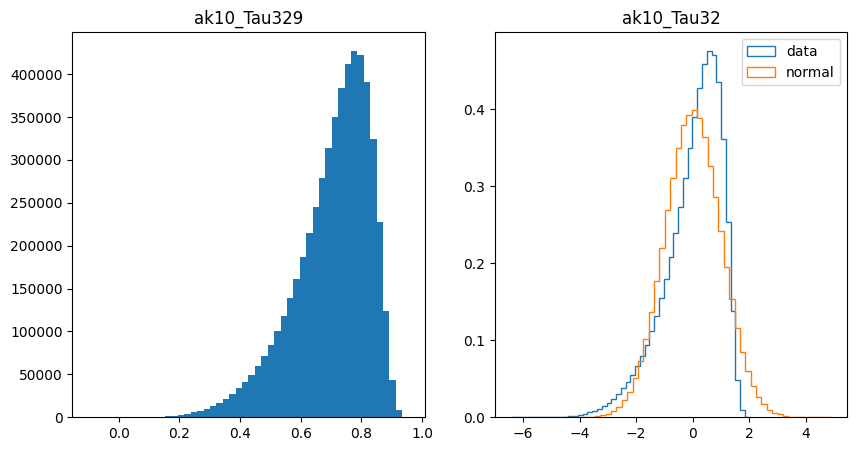

4.579231 0.32206616


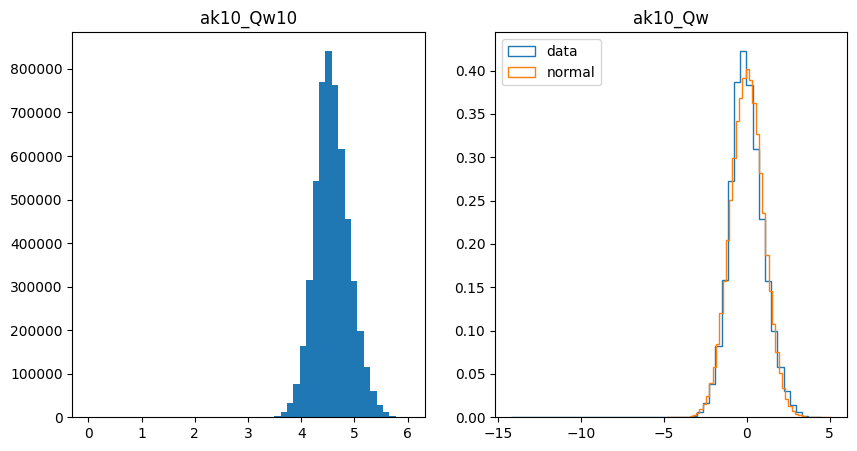

0.68345505 0.12794502


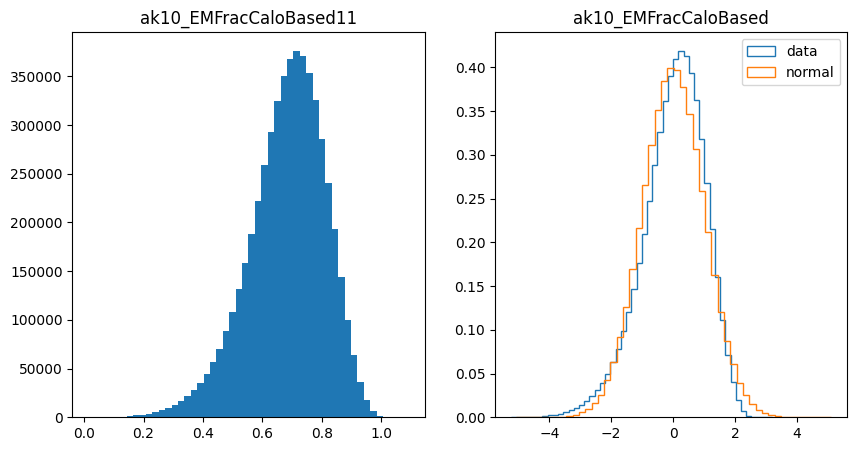

0.03280022 0.021793136


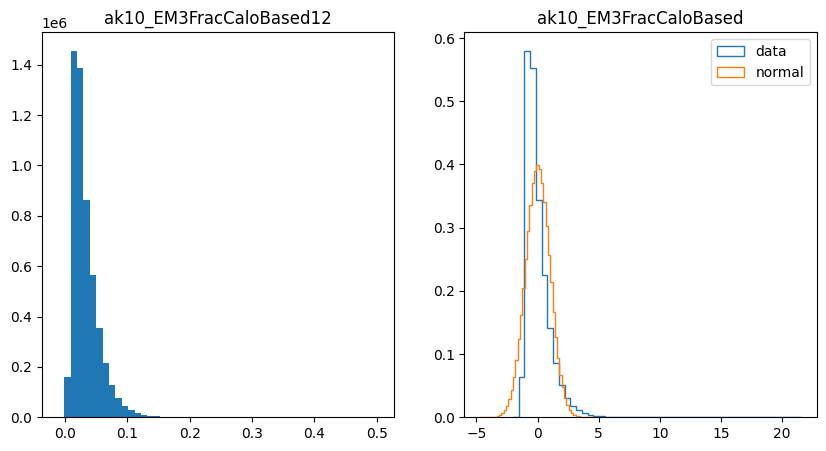

0.14092454 0.08241167


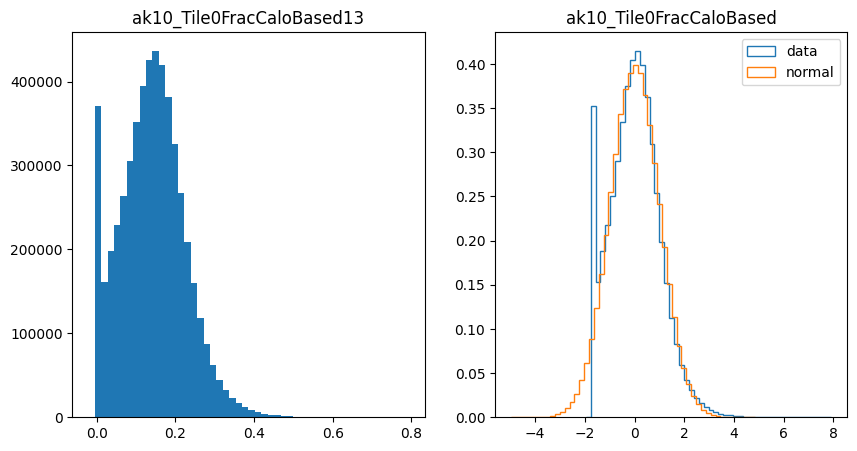

2.0837178 0.68784803


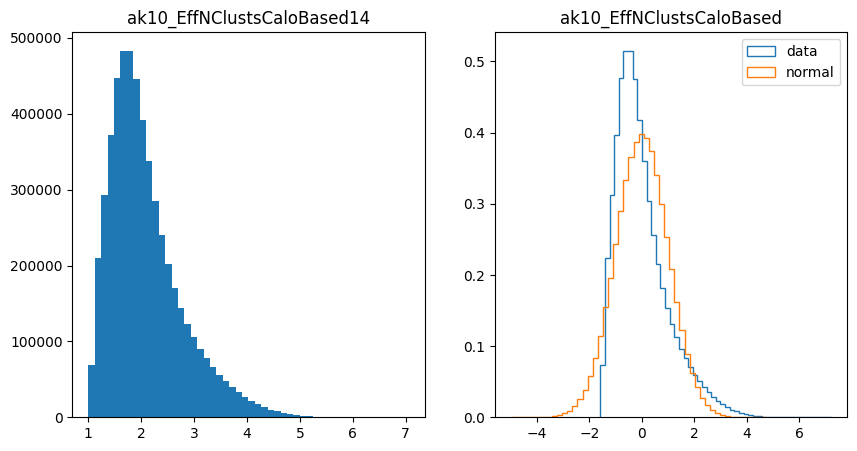

0.073700264 0.12156574


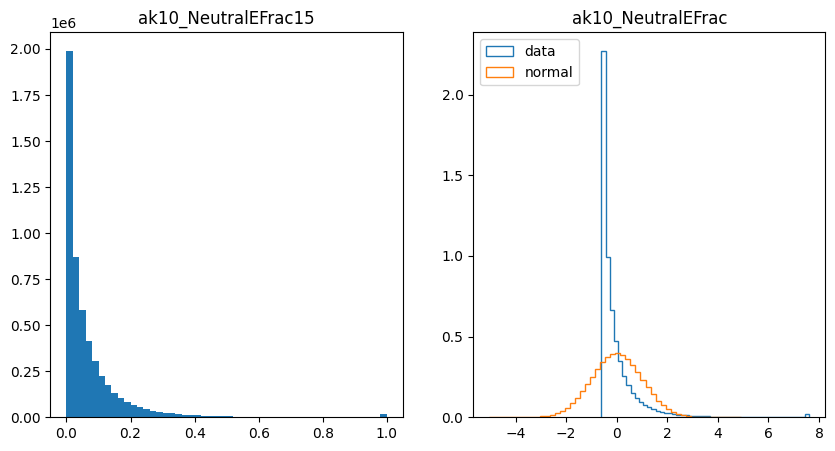

0.16002959 0.1312379


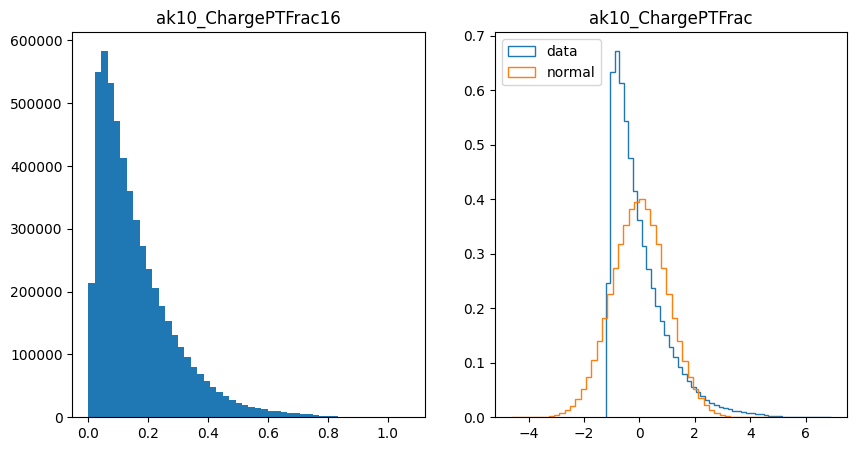

0.18449196 0.13492362


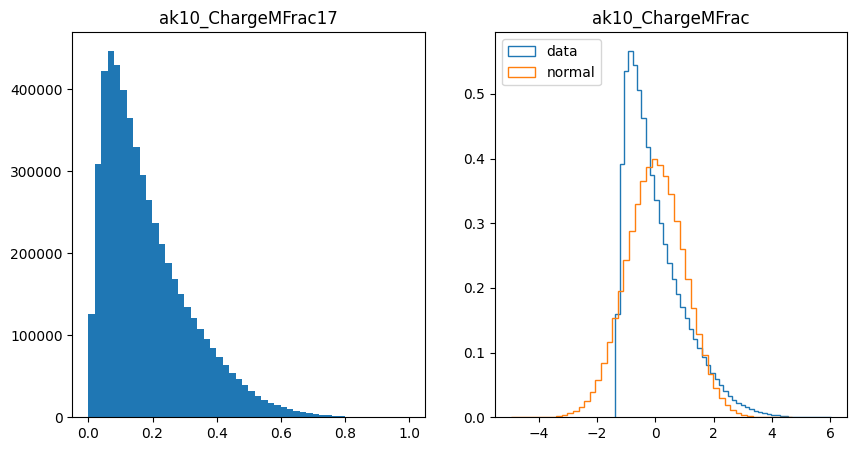

1.678377 0.1496065


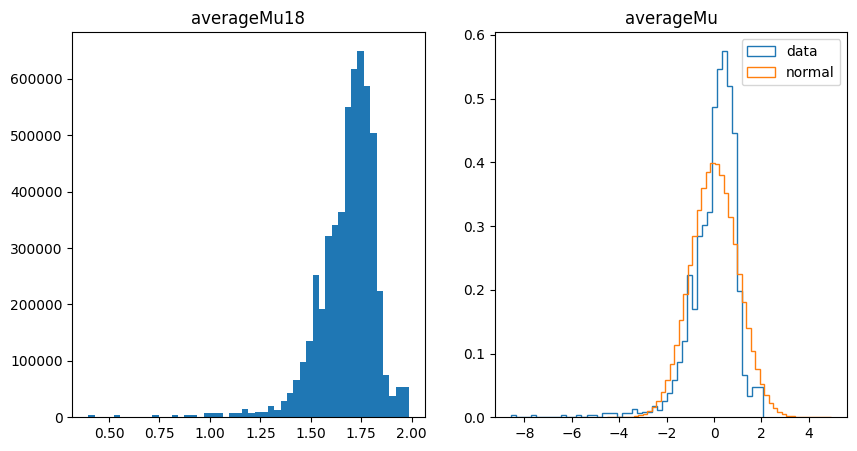

1.4461143 0.14328419


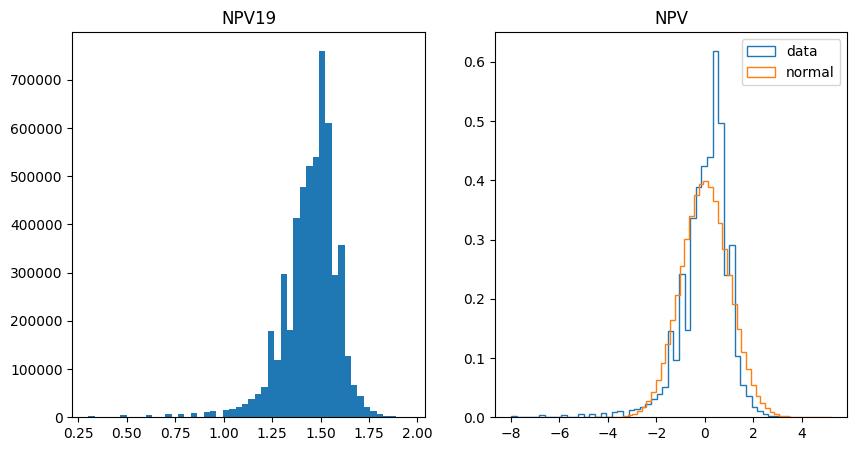

In [63]:
for i in range(inputs.shape[1]):
    data = inputs[:, i]
    if i in log_dims:
        data = np.log10(data+1)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].hist(data, bins=50)
    axs[0].set_title(keys_to_keep[i] + str(i))

    normal = np.random.standard_normal(size=1000000)
    mean, std = data.mean(), data.std()
    print(mean, std)
    axs[1].hist((data-mean)/std, bins=50, label='data', histtype='step', density=True)
    axs[1].hist(normal, bins=50, label='normal', histtype='step', density=True)
    axs[1].set_title(keys_to_keep[i])
    axs[1].legend()
    plt.show()


-19.981905 16.596544 -4.720653284878566 4.646039400096846


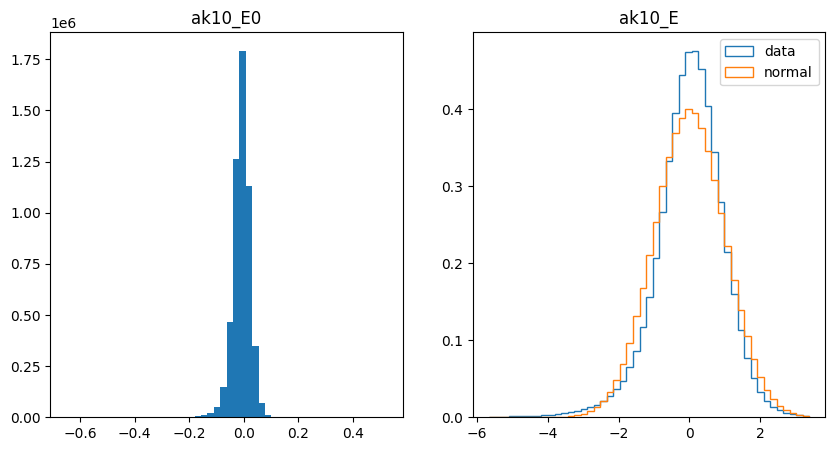

-17.613935 15.90012 -4.667217541757268 4.8515109549810935


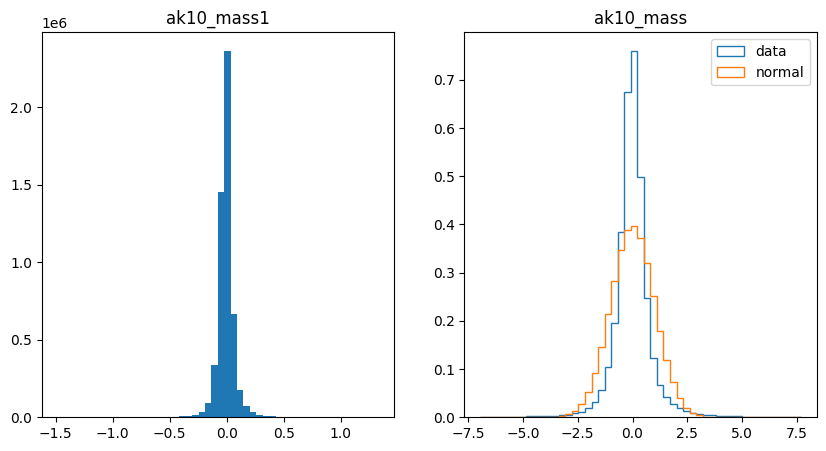

In [70]:
targets = full_data[:, :2]

for i in range(targets.shape[1]):
    data = targets[:, i]
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].hist(data, bins=50)
    axs[0].set_title(keys_to_keep[i] + str(i))

    normal = np.random.standard_normal(size=1000000)
    mean, std = data.mean(), data.std()
    data_normal = (data-mean)/std
    print(data_normal.min(), data_normal.max(), normal.min(), normal.max())
    bins = np.linspace(np.quantile(data_normal, 0.001), np.quantile(data_normal, 0.999), 50)
    axs[1].hist(data_normal, bins=bins, label='data', histtype='step', density=True)
    axs[1].hist(normal, bins=bins, label='normal', histtype='step', density=True)
    axs[1].set_title(keys_to_keep[i])
    axs[1].legend()
    plt.show()


In [25]:
keys_to_keep

['ak10_E',
 'ak10_mass',
 'ak10_rap',
 'ak10_groomMRatio',
 'ak10_Width',
 'ak10_Split12',
 'ak10_Split23',
 'ak10_C2',
 'ak10_D2',
 'ak10_Tau32',
 'ak10_Qw',
 'ak10_EMFracCaloBased',
 'ak10_EM3FracCaloBased',
 'ak10_Tile0FracCaloBased',
 'ak10_EffNClustsCaloBased',
 'ak10_NeutralEFrac',
 'ak10_ChargePTFrac',
 'ak10_ChargeMFrac',
 'averageMu',
 'NPV']

In [24]:
[key for key in keys if key not in keys_to_keep and "true" not in key]

['ak10_pt',
 'ak10_phi',
 'ak10_Angularity',
 'ak10_zg',
 'ak10_rg',
 'ak10_isoFrac',
 'sumPtak10jets']

In [13]:
print(full_data[:, 0].min())
print(full_data[:, 0].max())
print(full_data[:, 0].mean())
print(full_data[:, 0].std())
print(full_data[:, 0].var())
print(full_data[:, 0].sum())


-0.64999807
0.5244196
-0.008442616
0.03210682
0.001030848
-44963.18


In [ ]:


for i in indices:
    i = 23
    data = inputs[i]
    print(" Input ", i)
    print("Min: ", data.min(), "Max: ", data.max(), "Mean: ", data.mean(), "Std: ", data.std())
    log_data = np.log(data+1)
    print("Log Min: ", log_data.min(), "Log Max: ", log_data.max(), "Log Mean: ", log_data.mean(), "Log Std: ", log_data.std())
    print("\n")
    #plt.hist(log_data, bins=50)
    #plt.show()
    #plt.hist(data, bins=50)
    #plt.show()

    break



 Input  23
Min:  0.0 Max:  74.8797 Mean:  0.06218625 Std:  0.645589
Log Min:  0.0 Log Max:  4.3291492 Log Mean:  0.03142913 Log Std:  0.16754526




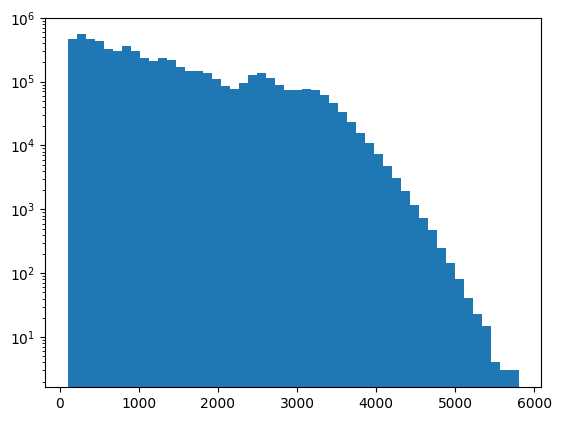

In [60]:
plt.hist(full_data[:, 3]/1000, bins=50)
plt.yscale('log')
plt.show()



In [43]:
true_mask = true_m < 0
rec_mask = rec_m < 0

print(true_mask.sum(), rec_mask.sum())

975 16488


In [48]:
np.sort(true_m[true_m < 0])


array([-1446.8098   , -1420.2793   , -1382.0182   , -1284.2614   ,
       -1188.0063   , -1008.01556  ,  -963.84143  ,  -920.4445   ,
        -903.1799   ,  -901.7021   ,  -900.06     ,  -897.48413  ,
        -894.95636  ,  -870.81805  ,  -855.27325  ,  -848.7613   ,
        -848.373    ,  -848.1008   ,  -848.0483   ,  -841.9058   ,
        -841.07855  ,  -839.31335  ,  -837.0886   ,  -825.78314  ,
        -821.06226  ,  -820.3829   ,  -799.1293   ,  -797.4454   ,
        -795.211    ,  -788.68176  ,  -787.25555  ,  -785.6879   ,
        -782.83057  ,  -782.2431   ,  -780.3279   ,  -775.5823   ,
        -775.5551   ,  -773.9752   ,  -771.4603   ,  -771.31903  ,
        -770.77045  ,  -767.2067   ,  -766.9749   ,  -764.0765   ,
        -761.54065  ,  -755.0538   ,  -753.51263  ,  -751.8172   ,
        -751.35455  ,  -739.99915  ,  -734.22516  ,  -732.52844  ,
        -730.38904  ,  -727.1598   ,  -725.2182   ,  -724.5297   ,
        -719.0684   ,  -717.1242   ,  -712.9099   ,  -707.6438

In [6]:
path_data_folder = "/remote/gpu07/huetsch/JetCalibration/data"

name = "Ak10Jet_1.root"

file = os.path.join(path_data_folder, name)
file = up.open(file)
tree = file['eventtree;46']
keys = tree.keys()

print(keys)
true_variables = ["ak10_true_E", "ak10_true_pt", "ak10_true_rap", "ak10_true_mass", "ak10_true_phi"]
rec_variables = ["ak10_E", "ak10_pt", "ak10_rap", "ak10_mass", "ak10_phi"]
conditional_variables = [key for key in keys if key not in true_variables and key not in rec_variables]

true_variables_data = [ak.to_numpy(tree[key].array()) for key in true_variables]
rec_variables_data = [ak.to_numpy(tree[key].array()) for key in rec_variables]
conditional_variables_data = [ak.to_numpy(tree[key].array()) for key in conditional_variables]

['ak10_E', 'ak10_pt', 'ak10_rap', 'ak10_phi', 'ak10_mass', 'ak10_true_E', 'ak10_true_pt', 'ak10_true_rap', 'ak10_true_mass', 'ak10_true_phi', 'ak10_Tau32', 'ak10_D2', 'ak10_Qw', 'ak10_Angularity', 'ak10_zg', 'ak10_rg', 'ak10_Split12', 'ak10_Split23', 'ak10_Width', 'ak10_C2', 'ak10_EMFracCaloBased', 'ak10_EM3FracCaloBased', 'ak10_Tile0FracCaloBased', 'ak10_EffNClustsCaloBased', 'ak10_NeutralEFrac', 'ak10_ChargePTFrac', 'ak10_ChargeMFrac', 'ak10_groomMRatio', 'ak10_isoFrac', 'averageMu', 'NPV', 'sumPtak10jets']


In [7]:
true_variables_data = np.array(true_variables_data)
rec_variables_data = np.array(rec_variables_data)
conditional_variables_data = np.array(conditional_variables_data)
fractions = rec_variables_data / true_variables_data
fractions = fractions[[0, 3], :]
full_data = np.concatenate([fractions.T, rec_variables_data.T, conditional_variables_data.T], axis=1)
print(full_data.shape)



(13000000, 29)


In [36]:
fractions.min()

-3888.083

In [28]:
rec_variables_data[:, 3].min()

0.3466864

In [29]:
true_variables_data[:, 3].min()

0.34339303

In [30]:
(rec_variables_data / true_variables_data)[:, 3].min()

0.965654

/tmp/ipykernel_4190180/3614147539.py:2: RuntimeWarning: invalid value encountered in log
  data = np.log(full_data[:, i]+1)


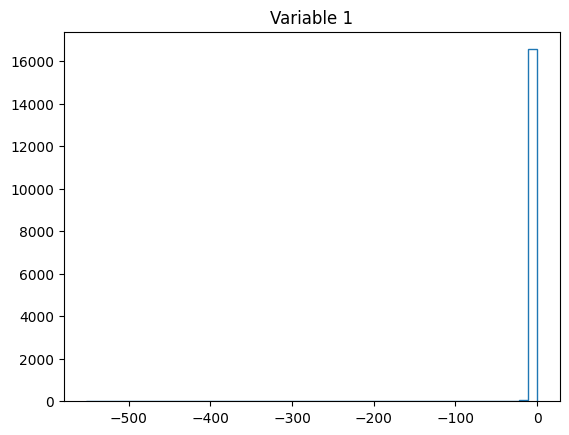

In [24]:
for i in range(1,2):
    data = np.log(full_data[:, i]+1)
    data = full_data[:, i]
    data = data[data<0]
    bins = np.linspace(np.quantile(data, 0.001), np.quantile(data, 0.999), 50)
    plt.hist(data, bins=bins, histtype='step', label='true')
    plt.title("Variable " + str(i))
    plt.show()


In [22]:
(full_data[:,1]<0).sum()

16753

In [5]:
np.save(os.path.join(path_data_folder, "Ak10Jet_1.npy"), full_data)

In [7]:
np.isnan(full_data).sum(0)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 14,  0,  0,  0,  0])

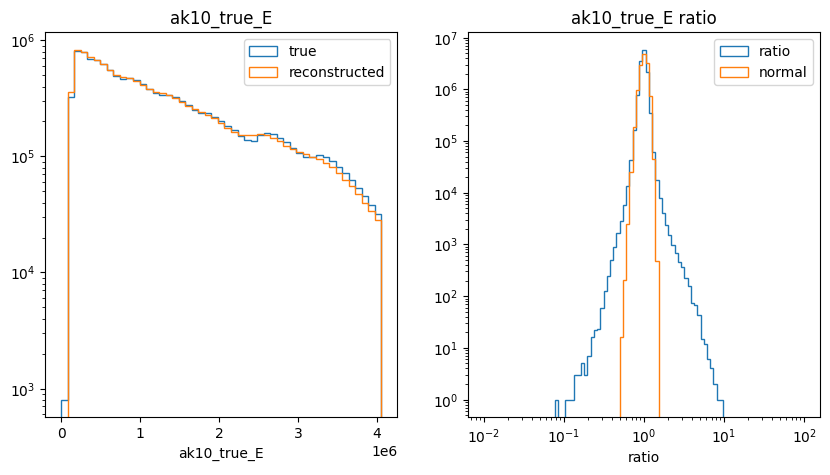

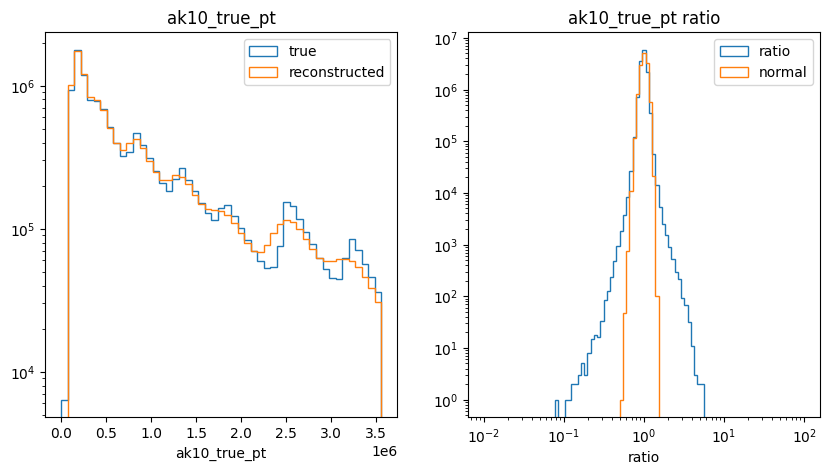

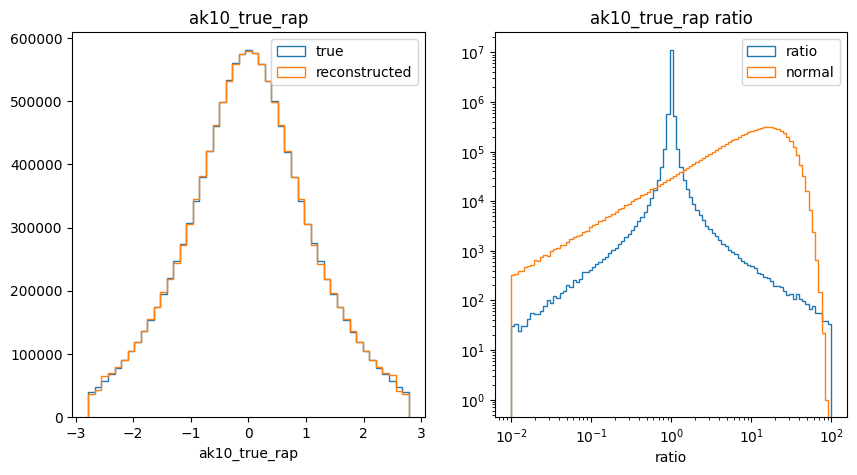

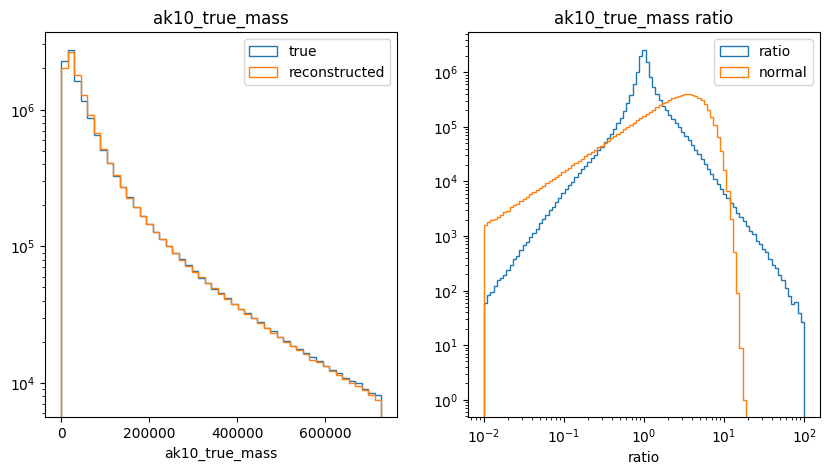

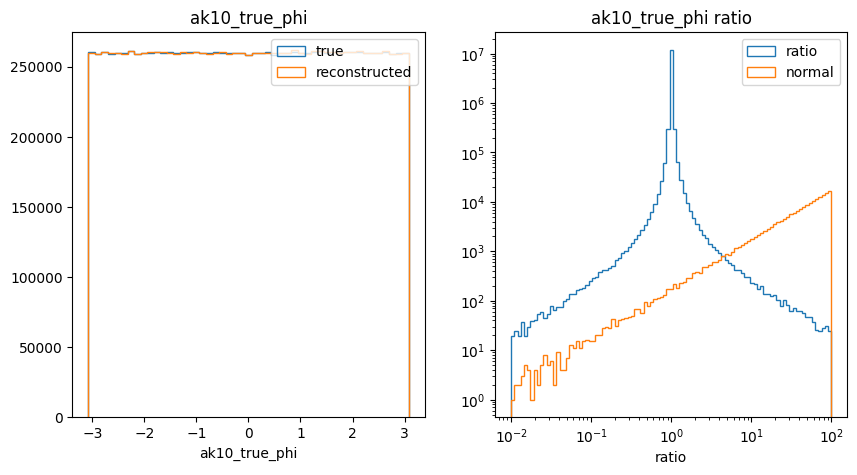

In [8]:
for i, variable in enumerate(true_variables):
    data_true = true_variables_data[i]
    data_rec = rec_variables_data[i]
    if "rap" in variable or "phi" in variable:
        bins = np.linspace(np.quantile(data_true, 0.01), np.quantile(data_true, 0.99), 50)
    else:
        bins = np.linspace(0, np.quantile(data_true, 0.99), 50)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].hist(data_true, bins=bins, histtype='step', label='true')
    axs[0].hist(data_rec, bins=bins, histtype='step', label='reconstructed')
    axs[0].legend()
    axs[0].set_title(variable)
    axs[0].set_xlabel(variable)
    if not "rap" in variable and not "phi" in variable:
        axs[0].set_yscale('log')

    ratio = data_rec / data_true
    #ratio = ratio/(ratio.std())
    normals = np.random.normal(1, ratio.std(), size=ratio.size)
    axs[1].hist(ratio, bins=np.logspace(np.log10(0.01), np.log10(100), 100), histtype='step', label='ratio')
    axs[1].hist(normals, bins=np.logspace(np.log10(0.01), np.log10(100), 100), histtype='step', label='normal')
    axs[1].set_title(variable + " ratio")
    axs[1].set_xlabel("ratio")
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[1].legend()
    plt.show()